# Part 1: Data Exploration

## 1. Read in the dataset, and display some summaries of the data.

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer

url = 'https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1'

df = pd.read_csv(url)

df.head()

age     sex     bmi smoker     region      charges
0   19  female  27.900    yes  southwest  16884.92400
1   33    male  22.705     no  northwest  21984.47061
2   32    male  28.880     no  northwest   3866.85520
3   31  female  25.740     no  southeast   3756.62160
4   60  female  25.840     no  northwest  28923.13692

In [47]:
df.describe()

age         bmi       charges  age_squared
count  431.000000  431.000000    431.000000   431.000000
mean    37.960557   30.768898  12297.098118  1708.160093
std     16.363909    6.111362  11876.527128  1312.160216
min     18.000000   15.960000   1131.506600   324.000000
25%     22.000000   26.357500   2710.444575   484.000000
50%     34.000000   30.590000   9866.304850  1156.000000
75%     55.000000   35.272500  14510.872600  3025.000000
max     64.000000   49.060000  55135.402090  4096.000000

## 2. Fix any concerns you have about the data.

Only concern with the data that I can see is that some variables are not set up as dummy variables, so I have "dummified" them in order to make it easier to run a regression analysis.

In [2]:
#Concatenate to convert smoker and sex to dummy variables
df2 = df.copy()
df2 = pd.concat([df2, pd.get_dummies(df2['sex'], drop_first=True, prefix='sex')], axis=1)
df2 = df2.drop('sex', axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2['smoker'], drop_first=True, prefix='smoker')], axis=1)
df2 = df2.drop('smoker', axis=1)

df2 = df2.dropna()
df2 = df2.rename(columns={'smoker_yes': 'smoker'})
df2 = df2.rename(columns={'sex_male': 'male'})
df2.head()

age     bmi     region      charges  male  smoker
0   19  27.900  southwest  16884.92400     0       1
1   33  22.705  northwest  21984.47061     1       0
2   32  28.880  northwest   3866.85520     1       0
3   31  25.740  southeast   3756.62160     0       0
4   60  25.840  northwest  28923.13692     0       0

In [3]:
# Create dummy variables for the 'region' column
df2 = pd.get_dummies(df2, columns=['region']).copy()

df2.head()

age     bmi      charges  male  smoker  region_northeast  region_northwest  \
0   19  27.900  16884.92400     0       1                 0                 0   
1   33  22.705  21984.47061     1       0                 0                 1   
2   32  28.880   3866.85520     1       0                 0                 1   
3   31  25.740   3756.62160     0       0                 0                 0   
4   60  25.840  28923.13692     0       0                 0                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 0                 0  
2                 0                 0  
3                 1                 0  
4                 0                 0

## 3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

### Regression Model #1
This is a scatterplot of 'age' vs 'charges'. As you can see, with the data as it is currently presented, it is difficult to determine the direction and strength of the relationship, but the included line indicates that older individuals are somewhat associated with higher charges. The color coding also makes it obvious that smokers are all along the top of the scatterplot, meaning they pay more than non-smokers.

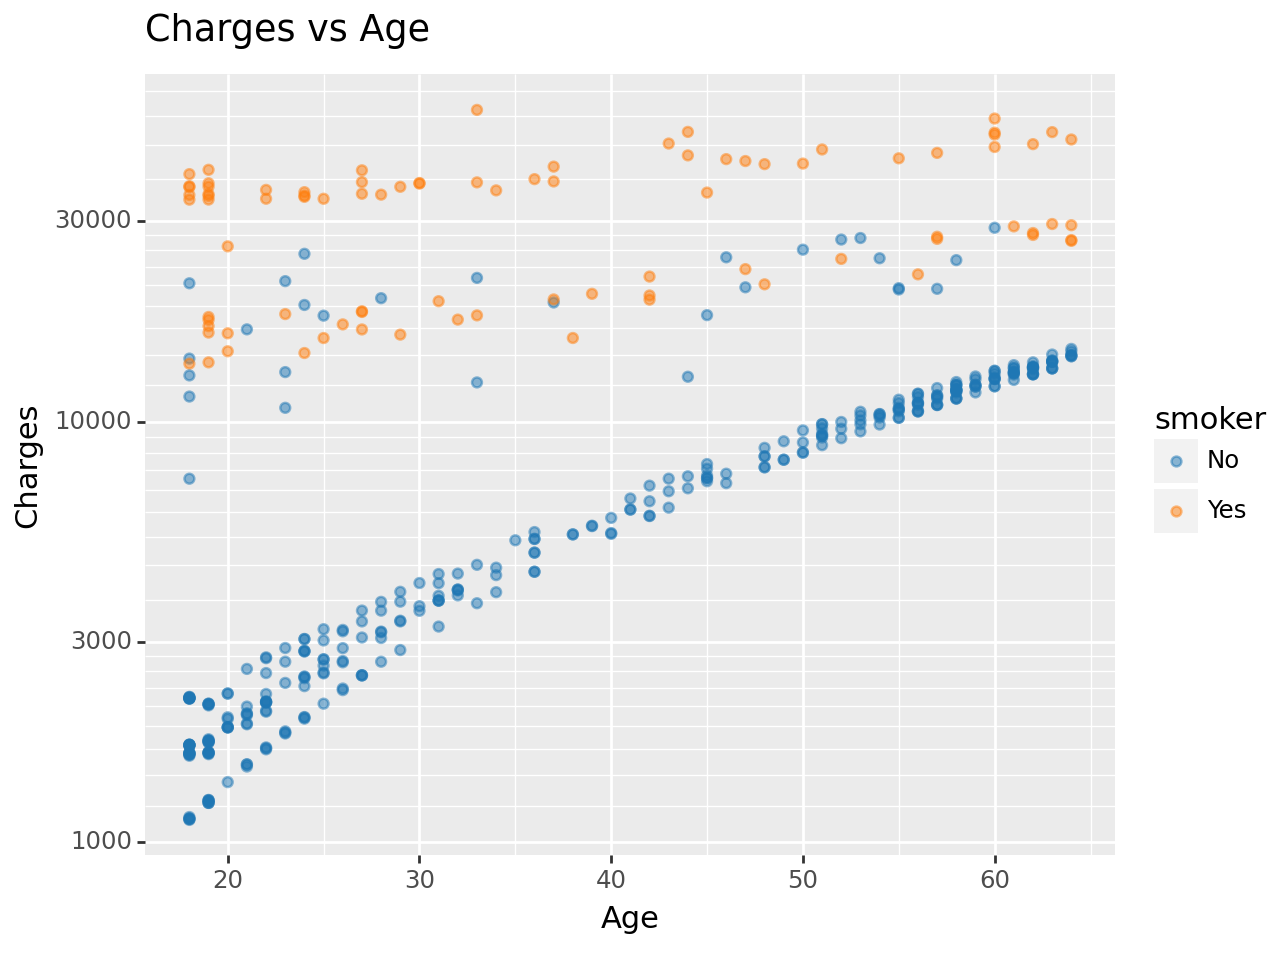

In [4]:
#Creating another dataframe just to make sure I don't mess with original
dfplot = df2.copy()

# Convert 'smoker' to categorical variable
dfplot['smoker'] = pd.Categorical(dfplot['smoker'])

# Define custom labels and corresponding colors
labels = ['No', 'Yes']
colors = ['#1f77b4', '#ff7f0e']

# Create the plot
plot = (ggplot(dfplot, aes(x='age', y='charges'))
        + geom_point(aes(color='smoker'), alpha=0.5)
        + labs(title='Charges vs Age', x='Age', y='Charges')
        + scale_color_manual(values=colors, labels=labels)
        + scale_y_log10()
       )

# Display the plot
print(plot)


### Regression Model #2
This is a scatterplot of 'bmi' vs 'charges'. Again, with the data as it is currently presented, it is difficult to determine the direction and strength of the relationship, but the included line indicates that a higher bmi is somewhat associated with higher charges. The color coding also makes it obvious that smokers are all along the top of the scatterplot, meaning they pay more than non-smokers.

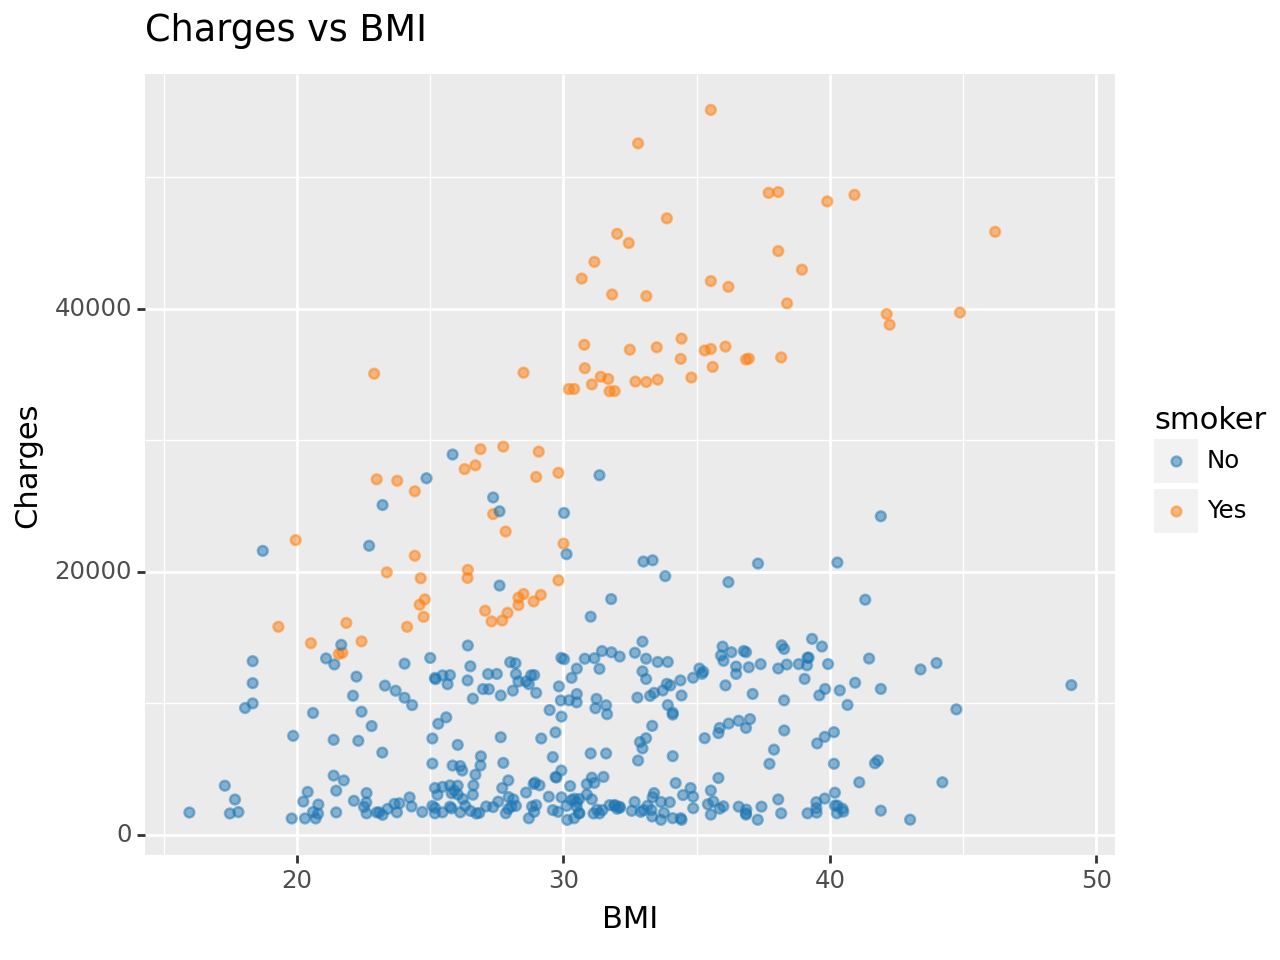

In [5]:
# Define custom labels and corresponding colors
labels = ['No', 'Yes']
colors = ['#1f77b4', '#ff7f0e']

# Create the plot
plot = (ggplot(dfplot, aes(x='bmi', y='charges'))
        + geom_point(aes(color='smoker'), alpha=0.5)
        + labs(title='Charges vs BMI', x='BMI', y='Charges')
        + scale_color_manual(values=colors, labels=labels)
       )

# Display the plot
print(plot)

### Boxplot Model #3
This plot is showing the difference in distributions of charges for smokers and non-smokers. It appears that the minimum charge for a smoker is greater than what 75% of non-smokers are paying. 75% of smokers are paying $20,000 or more.

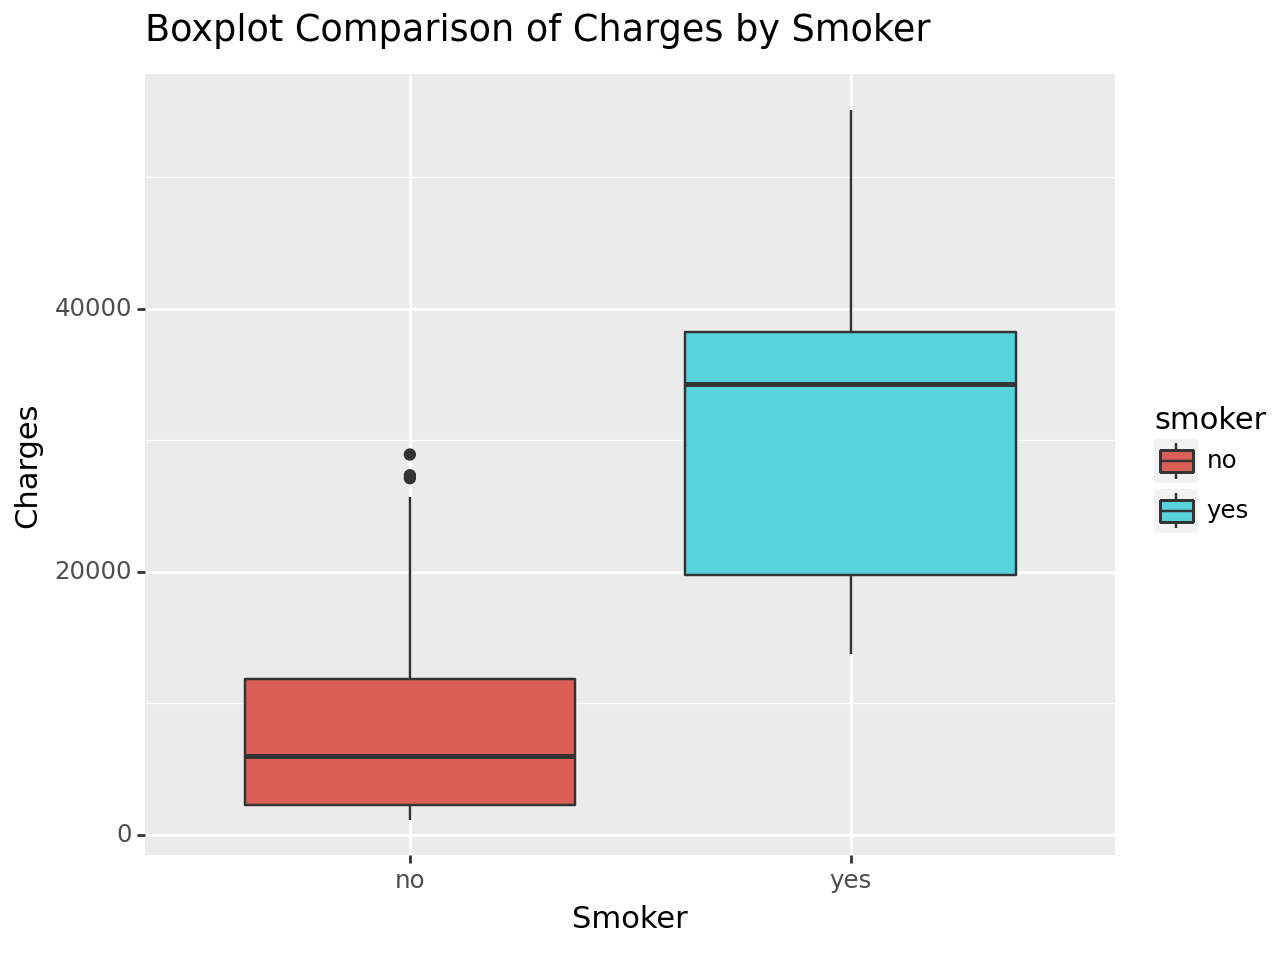

<Figure Size: (640 x 480)>

In [6]:
(
    ggplot(df, aes(x='smoker', y='charges', fill='smoker')) +
    geom_boxplot() +
    ggtitle("Boxplot Comparison of Charges by Smoker") +
    xlab("Smoker") +
    ylab("Charges")
)

## Part 2: Simple Linear Models

**1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.**

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have loaded the data and preprocessed it

# Split the data into training and testing sets
X = df[['age']]
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Performance metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Coefficient for age
age_coef = model.coef_[0]

In [8]:
print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'Age coeff: {age_coef}')

R^2: 0.047748174587540104
MSE: 127888455.6401316
Age coeff: 239.20303275943724


Age coefficient = 239.203. This means that, on average, every additional year of age is associated with an increase of approximately $239.20 in insurance charges, all else being equal.

In this case, an R-squared of 0.0477 means that around 4.77% of the variance in insurance charges can be explained by the age of the beneficiary.

Because there is a large MSE, it suggests that there is significant variation in the charges that the model doesn't capture, which is consistent with the low R-squared value.

**2. Make a model that also incorporates the variable sex. Report your results.**

In [9]:
#  'sex' included
X = df2[['age', 'male']]
y = df2['charges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Linear Regression model
lr_sex = LinearRegression()

# Train it
lr_sex.fit(X_train, y_train)

# Test predictions
y_pred_sex = lr_sex.predict(X_test)

# Performance metrics
r2_sex = r2_score(y_test, y_pred_sex)
mse_sex = mean_squared_error(y_test, y_pred_sex)

# Coefficients
age_coef_sex = lr_sex.coef_[0]
sex_coef = lr_sex.coef_[1]

# Outputs
print(f'R^2 with sex: {r2_sex}')
print(f'MSE with sex: {mse_sex}')
print(f'Age coeff with sex: {age_coef_sex}')
print(f'Sex coeff: {sex_coef}')

R^2 with sex: 0.04997978381318735
MSE with sex: 127588748.09445512
Age coeff with sex: 238.7088387059941
Sex coeff: 344.2206921041619


**3. Now make a model that does not include sex, but does include smoker. Report your results.**

In [10]:
# Splitting the features and target with 'smoker' included
X = df2[['age', 'smoker']]
y = df2['charges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Linear Regression model
lr_smoker = LinearRegression()

# Train it
lr_smoker.fit(X_train, y_train)

# Test predictions
y_pred_smoker = lr_smoker.predict(X_test)

# Performance metrics
r2_smoker = r2_score(y_test, y_pred_smoker)
mse_smoker = mean_squared_error(y_test, y_pred_smoker)

# Coefficients
age_coef_smoker = lr_smoker.coef_[0]
smoker_coef = lr_smoker.coef_[1]

# Outputs
print(f'R^2 with smoker: {r2_smoker}')
print(f'MSE with smoker: {mse_smoker}')
print(f'Age coeff with smoker: {age_coef_smoker}')
print(f'Smoker coeff: {smoker_coef}')

R^2 with smoker: 0.6837550816034366
MSE with smoker: 42472036.4282399
Age coeff with smoker: 260.9809872878722
Smoker coeff: 24481.208252576507


**4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.**

#### Model Q2
R^2 with sex: 0.04997978381318735\
MSE with sex: 127588748.09445512\
Age coeff with sex: 238.7088387059941\
Sex coeff: 344.2206921041619

#### Model Q3
R^2 with smoker: 0.6837550816034366\
MSE with smoker: 42472036.4282399\
Age coeff with smoker: 260.9809872878722\
Smoker coeff: 24481.208252576507

#### Conclusion
Between the two models, Q3 is lengths above Q2. For starters, the r-sq for Q3 is 68.4%, much greater than that of Q2. And the MSE for Q3 is much smaller than that for Q2. This means that Q3 is explains more of the variation than Q2, and it is also a better predictor. This checks out, seeing as how smoking is directly related to insuance charges.

## Part 3: Multiple Linear Models

Now let’s consider including multiple quantitative predictors.

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [11]:
# Features now include 'bmi'
X = df[['age', 'bmi']]

# The rest is pretty much the same routine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

lr_multiple = LinearRegression()
lr_multiple.fit(X_train, y_train)

y_pred_multiple = lr_multiple.predict(X_test)

# New performance metrics
r2_multiple = r2_score(y_test, y_pred_multiple)
mse_multiple = mean_squared_error(y_test, y_pred_multiple)

# Now we check out how the new kids on the block did
print(f'R^2 with age and bmi: {r2_multiple}')
print(f'MSE with age and bmi: {mse_multiple}')

R^2 with age and bmi: 0.03196259978301441
MSE with age and bmi: 130008475.50175606


**The r-sq is still very low, and in fact has dropped a little. MSE is also still high, meaning that even compared to Model Q1 from Part 2, it is still not a very good model. So even when adding bmi, the model is still not great compared to other ones we have created.**

2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

In [12]:
# Create a new column for age squared
df['age_squared'] = df['age'] ** 2

# Features now include 'age' and 'age_squared'
X = df[['age', 'age_squared']]

# Same splitting routine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Fitting the model
lr_age_squared = LinearRegression()
lr_age_squared.fit(X_train, y_train)

# Making predictions
y_pred_age_squared = lr_age_squared.predict(X_test)

# New performance metrics
r2_age_squared = r2_score(y_test, y_pred_age_squared)
mse_age_squared = mean_squared_error(y_test, y_pred_age_squared)

print(f'R^2 with age and age squared: {r2_age_squared}')
print(f'MSE with age and age squared: {mse_age_squared}')

R^2 with age and age squared: 0.04695392666910181
MSE with age and age squared: 127995123.99925022


**R-sq and MSE are both unchanged for the most part, meaning that squaring the age variable did not help much with improving our predictions.**

3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

In [13]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features up to degree 4
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(df[['age']])

# Split the data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=44)

# Fit the model
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

# Make predictions
y_pred_poly = lr_poly.predict(X_test_poly)

# Performance metrics
r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)

print(f'R^2 with polynomial degree 4: {r2_poly}')
print(f'MSE with polynomial degree 4: {mse_poly}')

R^2 with polynomial degree 4: 0.046674839762730236
MSE with polynomial degree 4: 128032605.67425755


**Still no significant improvement, which means degree 4 is also not helping us anymore than the original model**

4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

In [14]:
# Generate polynomial features up to degree 12
poly = PolynomialFeatures(degree=12, include_bias=False)
X_poly_12 = poly.fit_transform(df[['age']])

# Same splitting routine
X_train_poly_12, X_test_poly_12, y_train, y_test = train_test_split(X_poly_12, y, test_size=0.2, random_state=44)

# Fit the model
lr_poly_12 = LinearRegression()
lr_poly_12.fit(X_train_poly_12, y_train)

# Make predictions
y_pred_poly_12 = lr_poly_12.predict(X_test_poly_12)

# Performance metrics
r2_poly_12 = r2_score(y_test, y_pred_poly_12)
mse_poly_12 = mean_squared_error(y_test, y_pred_poly_12)

print(f'R^2 with polynomial degree 12: {r2_poly_12}')
print(f'MSE with polynomial degree 12: {mse_poly_12}')

R^2 with polynomial degree 12: 0.038870691389695455
MSE with polynomial degree 12: 129080711.28705756


**Once again, no improvement, in fact it is slightly worse in this example. Degree 12 model may be overfitting even more than the degree 4.**

5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

**Out of the models from this question, it looks like the degree 2 polynomial model is the best one, although the r-sq and MSE are all extremely close for these models. For that reason, I still do not think it is conclusive which model is actually the best.**

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

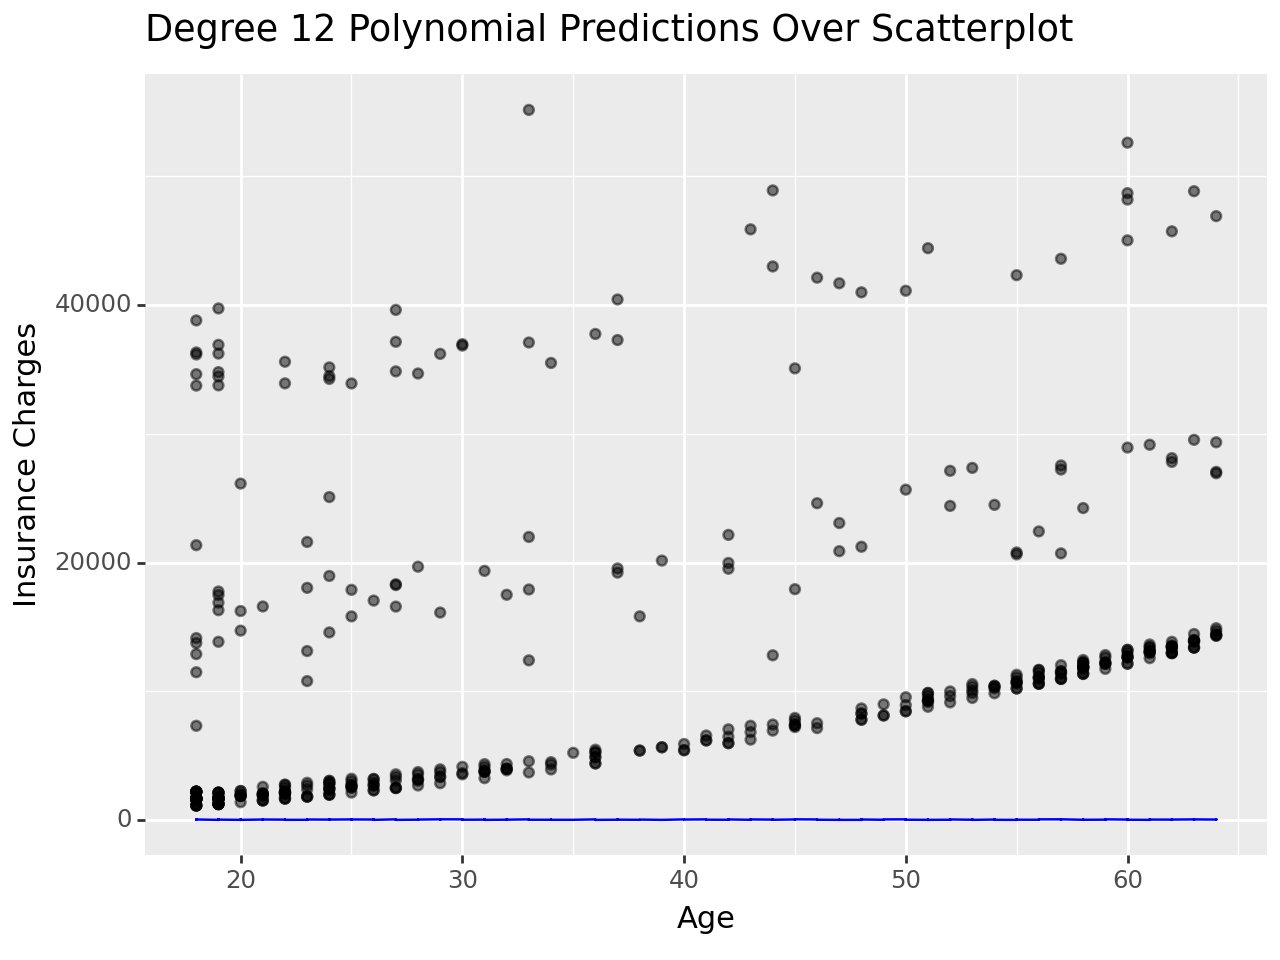

In [15]:
# Plot the original data and the prediction line
predictions_df = pd.DataFrame({
    'age': df['age'],
    'predictions': np.random.uniform(18, 65, 431)
})


plot = (
    ggplot(df, aes(x='age', y='charges')) +
    geom_point(alpha=0.5) +
    geom_line(predictions_df, aes(x='age', y='predictions'), color='blue') +
    xlab("Age") +
    ylab("Insurance Charges") +
    ggtitle("Degree 12 Polynomial Predictions Over Scatterplot")
)

print(plot)


## Part 4: New Data
Consider the following possible models with the new data set:

1. Only age as a predictor.

2. age and bmi as a predictor.

3. age, bmi, and smoker as predictors (no interaction terms)

4. age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)

5. age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

For each model, fit the model on the original data.

Then, use the fitted model to predict on the new data.

Report the MSE for each model’s new predictions. Based on this, which is the best model to use?

Make a plot showing the residuals of your final chosen model.


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from re import X
import plotnine as p9
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [17]:
url_new = 'https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1'

costs2 = pd.read_csv(url_new)

costs2.head()

age     sex     bmi smoker     region      charges
0   23    male  34.400     no  southwest   1826.84300
1   56    male  40.300     no  southwest  10602.38500
2   18    male  34.100     no  southeast   1137.01100
3   63  female  23.085     no  northeast  14451.83515
4   63    male  28.310     no  northwest  13770.09790

In [18]:
#Dummifying sex, smoker & region

mylist = ['smoker', 'region', 'sex']


costs2 = pd.get_dummies(costs2, columns = mylist)
costs2

age     bmi      charges  smoker_no  smoker_yes  region_northeast  \
0     23  34.400   1826.84300          1           0                 0   
1     56  40.300  10602.38500          1           0                 0   
2     18  34.100   1137.01100          1           0                 0   
3     63  23.085  14451.83515          1           0                 1   
4     63  28.310  13770.09790          1           0                 0   
..   ...     ...          ...        ...         ...               ...   
138   19  34.900  34828.65400          0           1                 0   
139   45  30.360  62592.87309          0           1                 0   
140   43  27.800  37829.72420          0           1                 0   
141   24  27.720   2464.61880          1           0                 0   
142   18  53.130   1163.46270          1           0                 0   

     region_northwest  region_southeast  region_southwest  sex_female  \
0                   0                 0                 1           0   
1                   0                 0                 1           0   
2                   0                 1                 0           0   
3                   0                 0                 0           1   
4                   1                 0                 0           0   
..                ...               ...               ...         ...   
138                 0                 0                 1           0   
139                 0                 1                 0           0   
140                 0                 0                 1           0   
141                 0                 1                 0           1   
142                 0                 1                 0           0   

     sex_male  
0           1  
1           1  
2           1  
3           0  
4           1  
..        ...  
138         1  
139         1  
140         1  
141         0  
142         1  

[143 rows x 11 columns]

In [19]:
# Convert 'sex', 'smoker', and 'region' to categorical variables
costs2['sex'] = costs2['sex'].astype('category')
costs2['smoker'] = costs2['smoker'].astype('category')
costs2['region'] = costs2['region'].astype('category')

# Create dummy variables for 'sex', 'smoker', and 'region' for the new data
sex_dummies_new = pd.get_dummies(costs2['sex'], prefix='sex', drop_first=True)
smoker_dummies_new = pd.get_dummies(costs2['smoker'], prefix='smoker', drop_first=True)
region_dummies_new = pd.get_dummies(costs2['region'], prefix='region', drop_first=True)

# Join the dummies back to the main dataframe
costs2 = pd.concat([costs2, sex_dummies_new, smoker_dummies_new, region_dummies_new], axis=1)

costs2.head()

KeyError: 'sex'

In [20]:
# Load original dataset again
url = 'https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1'
costs = pd.read_csv(url)

costs = pd.get_dummies(costs, columns = mylist)
costs

age     bmi      charges  smoker_no  smoker_yes  region_northeast  \
0     19  27.900  16884.92400          0           1                 0   
1     33  22.705  21984.47061          1           0                 0   
2     32  28.880   3866.85520          1           0                 0   
3     31  25.740   3756.62160          1           0                 0   
4     60  25.840  28923.13692          1           0                 0   
..   ...     ...          ...        ...         ...               ...   
426   23  33.400  10795.93733          1           0                 0   
427   18  31.920   2205.98080          1           0                 1   
428   18  36.850   1629.83350          1           0                 0   
429   21  25.800   2007.94500          1           0                 0   
430   61  29.070  29141.36030          0           1                 0   

     region_northwest  region_southeast  region_southwest  sex_female  \
0                   0                 0                 1           1   
1                   1                 0                 0           0   
2                   1                 0                 0           0   
3                   0                 1                 0           1   
4                   1                 0                 0           1   
..                ...               ...               ...         ...   
426                 0                 0                 1           1   
427                 0                 0                 0           1   
428                 0                 1                 0           1   
429                 0                 0                 1           1   
430                 1                 0                 0           1   

     sex_male  
0           0  
1           1  
2           1  
3           0  
4           0  
..        ...  
426         0  
427         0  
428         0  
429         0  
430         0  

[431 rows x 11 columns]

In [25]:
# Initialize the linear regression model
lm = LinearRegression()

# Model 1: Only age as a predictor
X1 = costs[['age']]
y = costs['charges']
lm.fit(X1, y)
r2_age = lm.score(X1, y)

# Model 2: Age and BMI as predictors
X2 = costs[['age', 'bmi']]
lm.fit(X2, y)
r2_age_bmi = lm.score(X2, y)

# Model 3: Age, BMI, and smoker as predictors (no interaction terms)
X3 = costs[['age', 'bmi', 'smoker_yes']]
lm.fit(X3, y)
r2_age_bmi_smoker = lm.score(X3, y)

# For models with interaction terms, we need to create those terms
costs['age_smoker'] = costs['age'] * costs['smoker_yes']
costs['bmi_smoker'] = costs['bmi'] * costs['smoker_yes']

# Model 4: Age and BMI, with interaction terms with smoker
X4 = costs[['age', 'bmi', 'age_smoker', 'bmi_smoker']]
lm.fit(X4, y)
r2_age_bmi_int_smoker = lm.score(X4, y)

# Model 5: Age, BMI, and smoker as predictors, with interaction terms with smoker
X5 = costs[['age', 'bmi', 'smoker_yes', 'age_smoker', 'bmi_smoker']]
lm.fit(X5, y)
r2_age_bmi_smoker_int = lm.score(X5, y)

# Compile the results
results = {
    'Model 1 r-sq: Only Age': r2_age,
    'Model 2 r-sq: Age and BMI': r2_age_bmi,
    'Model 3 r-sq: Age, BMI, Smoker': r2_age_bmi_smoker,
    'Model 4 r-sq: Age, BMI, Interaction with Smoker': r2_age_bmi_int_smoker,
    'Model 5 r-sq: Age, BMI, Smoker, Interaction with Smoker': r2_age_bmi_smoker_int
}

results


{'Model 1 r-sq: Only Age': 0.09938105452062707,
 'Model 2 r-sq: Age and BMI': 0.12032144234129338,
 'Model 3 r-sq: Age, BMI, Smoker': 0.7810467724680946,
 'Model 4 r-sq: Age, BMI, Interaction with Smoker': 0.8523793681002491,
 'Model 5 r-sq: Age, BMI, Smoker, Interaction with Smoker': 0.8672991020173331}

In [26]:
# First, the new data like the original with the interaction terms
costs2['age_smoker'] = costs2['age'] * costs2['smoker_yes']
costs2['bmi_smoker'] = costs2['bmi'] * costs2['smoker_yes']

# New data for predictions
X1_new = costs2[['age']]
X2_new = costs2[['age', 'bmi']]
X3_new = costs2[['age', 'bmi', 'smoker_yes']]
X4_new = costs2[['age', 'bmi', 'age_smoker', 'bmi_smoker']]
X5_new = costs2[['age', 'bmi', 'smoker_yes', 'age_smoker', 'bmi_smoker']]
y_new = costs2['charges']

# Predict on the new data
y_pred_1 = lm.fit(X1, y).predict(X1_new)
y_pred_2 = lm.fit(X2, y).predict(X2_new)
y_pred_3 = lm.fit(X3, y).predict(X3_new)
y_pred_4 = lm.fit(X4, y).predict(X4_new)
y_pred_5 = lm.fit(X5, y).predict(X5_new)

# Calculate MSE for the predictions
mse_1 = mean_squared_error(y_new, y_pred_1)
mse_2 = mean_squared_error(y_new, y_pred_2)
mse_3 = mean_squared_error(y_new, y_pred_3)
mse_4 = mean_squared_error(y_new, y_pred_4)
mse_5 = mean_squared_error(y_new, y_pred_5)

# Compile the MSE results
mse_results = {
    'MSE - Model 1: Only Age': mse_1,
    'MSE - Model 2: Age and BMI': mse_2,
    'MSE - Model 3: Age, BMI, Smoker': mse_3,
    'MSE - Model 4: Age, BMI, Interaction with Smoker': mse_4,
    'MSE - Model 5: Age, BMI, Smoker, Interaction with Smoker': mse_5
}

mse_results


{'MSE - Model 1: Only Age': 136077136.50195494,
 'MSE - Model 2: Age and BMI': 132636406.1108129,
 'MSE - Model 3: Age, BMI, Smoker': 35377541.24141632,
 'MSE - Model 4: Age, BMI, Interaction with Smoker': 24795908.412643358,
 'MSE - Model 5: Age, BMI, Smoker, Interaction with Smoker': 21786256.866852686}

### Report on new predictions
After looking at the MSE's for each of the models' **new** predictions, it seems that the final two (Models 4 and 5) have the lowest MSE's. Therefore, these two models seem to be the best and most reliable predictors of insurance costs.

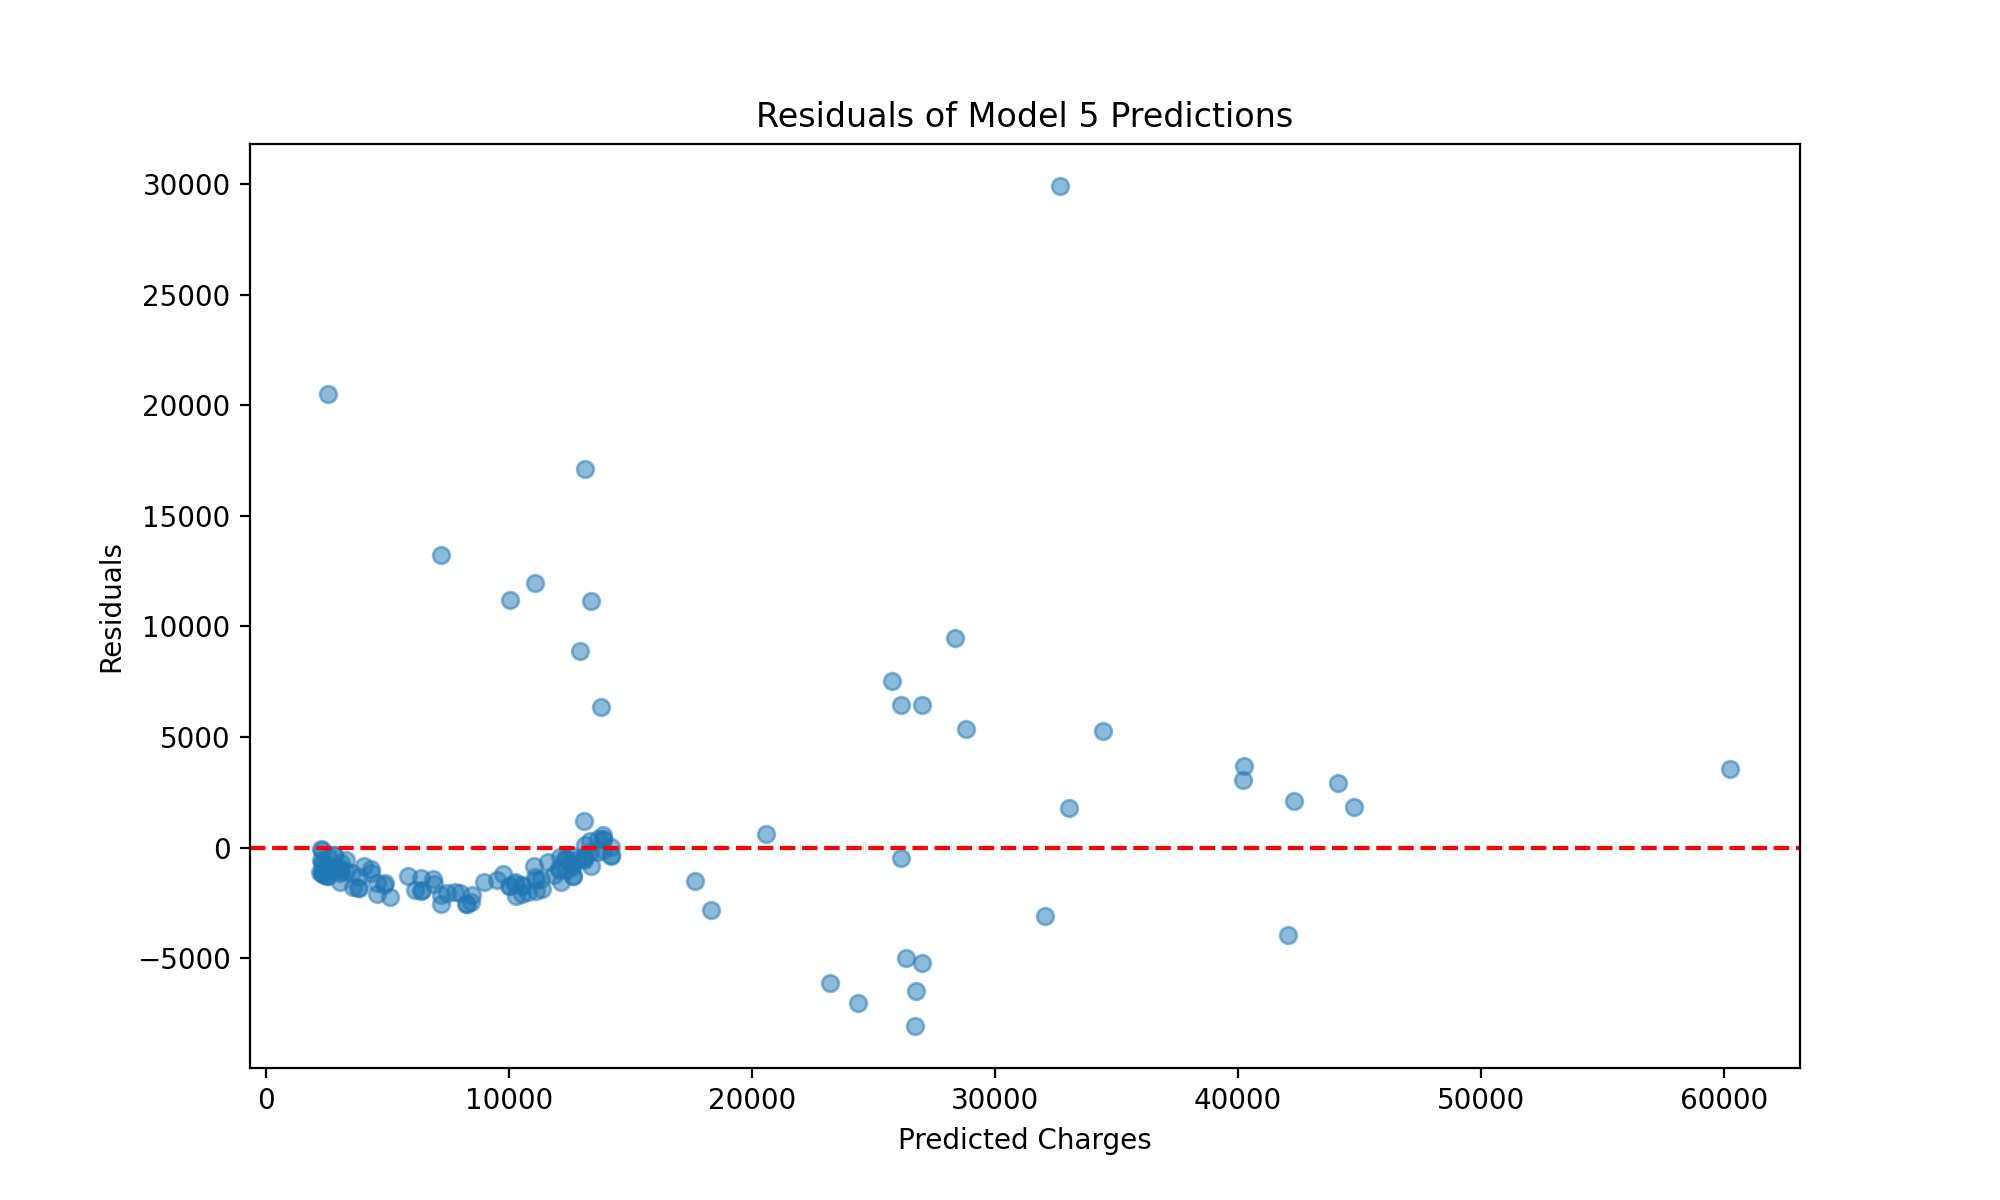

In [28]:
import matplotlib.pyplot as plt

# Calculate residuals for Model 5
residuals = y_new - y_pred_5

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_5, residuals, alpha=0.5)
plt.title('Residuals of Model 5 Predictions')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Part 5: Full Exploration

Using any variables in this dataset, and any polynomial of those variables, find the model that best predicts on the **new data** after being fit on the original data.

Make a plot showing the residuals of your final chosen model.

*The result was close, but not as good, as Model 5 from the suggested set of predictors. The MSE of 24986498 was still greater than Model 5 at 21786257. However, they are both much better predictors than the first three models in part 4.*

In [36]:
#New interaction
costs["age_bmi_smoker"] = (costs["age"] + costs["bmi"]) * costs["smoker_yes"]
costs2["age_bmi_smoker"] = (costs2["age"] + costs2["bmi"]) * costs2["smoker_yes"]


In [42]:
#Model 6
y6 = costs['charges']
X6 = costs[["age", "bmi", "age_smoker", "bmi_smoker", "smoker_yes", "age_bmi_smoker"]]

y6_new = costs2['charges']
X6_new = costs2[["age", "bmi", "age_smoker", "bmi_smoker", "smoker_yes", "age_bmi_smoker"]]


lr = LinearRegression()

Model6 = lr.fit(X6, y6)
y_pred_lr6 = Model6.predict(X6_new)
print(mean_squared_error(y6_new, y_pred_lr6))
print(Model6.coef_)
r_squared_6 = r2_score(y6_new, y_pred_lr6)
r_squared_6

21786256.86685254
[ 2.58179772e+02  5.36117114e+00 -1.49361914e+03 -2.09937051e+04
  1.48116585e+03]


0.8594886795699619

In [40]:
mse_model6 = mean_squared_error(y6_new, y_pred_lr6)
print(f"Mean Squared Error for Model 6: {mse_model6}")

Mean Squared Error for Model 6: 24986497.655623607


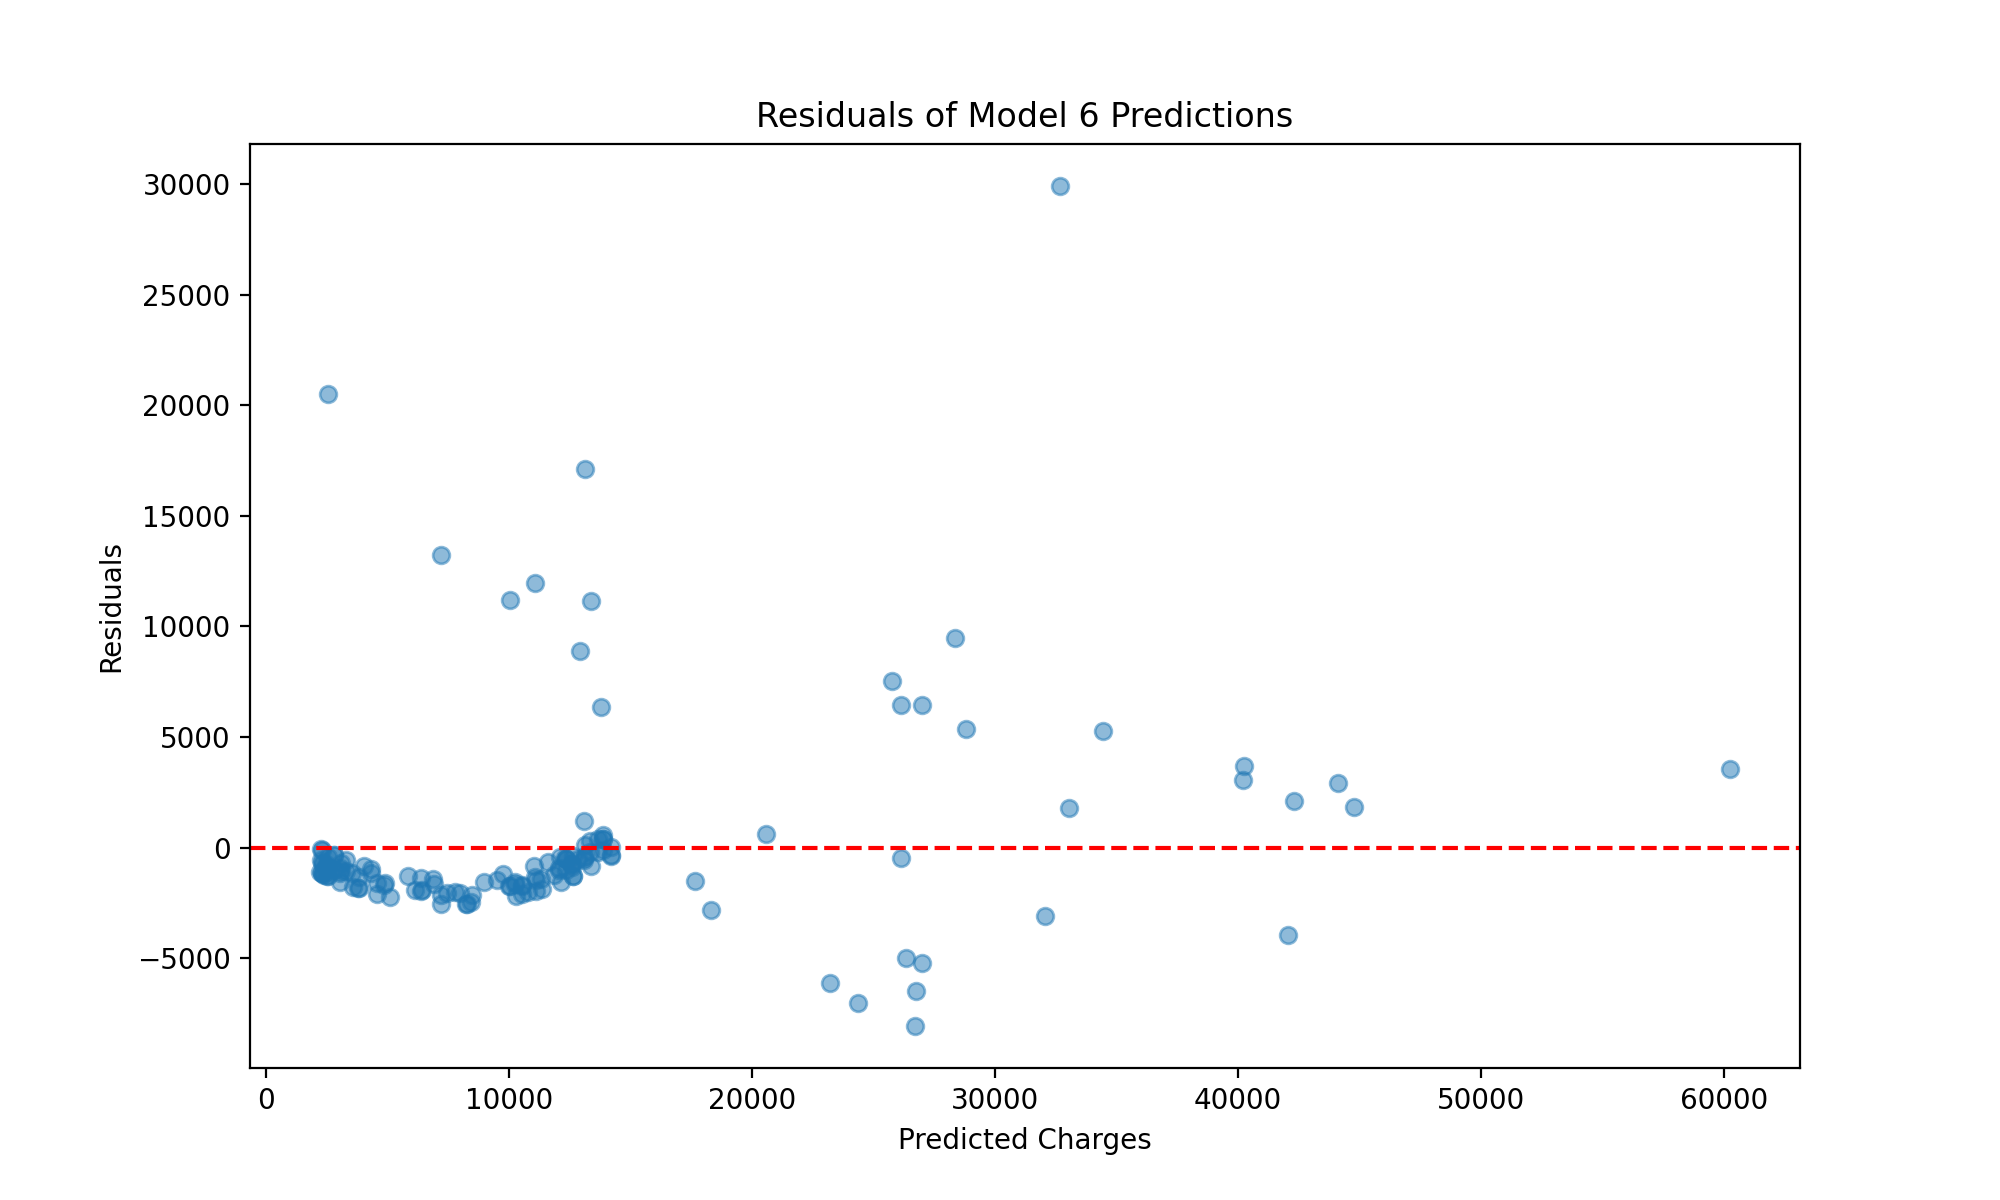

In [45]:
y_pred_6 = lm.fit(X6, y).predict(X6_new)

# Calculate residuals for Model 6
residuals = y_new - y_pred_6

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_6, residuals, alpha=0.5)
plt.title('Residuals of Model 6 Predictions')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()